<a href="https://colab.research.google.com/github/Priyanshumg/Portfolio-Optimization-with-Sharpe-Ratio-Maximization/blob/main/Portfolio_Optimization_with_Sharpe_Ratio_Maximization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta

**Defining Tickers and Time Range**

In [ ]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

Setting Start and End Date for Dataset

In [ ]:
end_date = datetime.today()
start_date = end_date - timedelta(days=365)
print(f"StartDate: {start_date}, EndDate: {end_date}")

StartDate: 2024-08-19 05:12:26.596672, EndDate: 2025-08-19 05:12:26.596672


# **Downloading Adjusted Close Prices**

**Creating an Empty DataFrame to store the adjusted close price**

In [ ]:
adj_close_df = pd.DataFrame()

In [ ]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    if 'Adj Close' in data.columns:
        adj_close_df[ticker] = data['Adj Close']
    elif 'Close' in data.columns:   # fallback if no Adj Close
        adj_close_df[ticker] = data['Close']
    else:
        print(f"No price data found for {ticker}")

/tmp/ipython-input-566370483.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-566370483.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-566370483.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-566370483.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-566370483

In [ ]:
adj_close_df.shape

(250, 5)

Calculating Daily Returns using Lognormal Returns

In [ ]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns.head()

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2024-08-19,NaN,NaN,NaN,NaN,NaN
2024-08-20,-0.001627,0.002955,0.003663,-0.002101,-0.002433
2024-08-21,0.003431,0.002144,-0.001335,0.004653,0.005004
2024-08-22,-0.007879,-0.004023,-0.012047,-0.015982,-0.008500
2024-08-23,0.010569,0.004424,0.011487,0.010787,0.012579


Checking for any nulll value

In [ ]:
log_returns.isnull().sum()

,0
SPY,1
BND,1
GLD,1
QQQ,1
VTI,1


In [ ]:
log_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2024-08-19 to 2025-08-18
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     249 non-null    float64
 1   BND     249 non-null    float64
 2   GLD     249 non-null    float64
 3   QQQ     249 non-null    float64
 4   VTI     249 non-null    float64
dtypes: float64(5)
memory usage: 11.7 KB


Dropping Null Rows

In [ ]:
log_returns = log_returns.dropna(axis = 0)

In [ ]:
log_returns.isnull().sum()

,0
SPY,0
BND,0
GLD,0
QQQ,0
VTI,0


# **Calculating Covariance Matrix**

Calculating Covariance matrix using log returns

In [ ]:
trading_days_in_year = 252

In [ ]:
cov_matrix = log_returns.cov() * trading_days_in_year

In [ ]:
cov_matrix.head()

,SPY,BND,GLD,QQQ,VTI
SPY,0.038432,0.000754,0.001043,0.045394,0.038342
BND,0.000754,0.002510,0.001572,0.000297,0.000778
GLD,0.001043,0.001572,0.030420,0.001637,0.000936
QQQ,0.045394,0.000297,0.001637,0.057171,0.045242
VTI,0.038342,0.000778,0.000936,0.045242,0.038416


# **Defining Portfolio Performance Metrics**

**Calculating portfolio standard deviation**

In [ ]:
def standard_deviation(weights, cov_matrix):
  variance = weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

**Calculating Expected Returns which will be based on historical returns**

In [ ]:
def expected_returns(weights, log_returns):
  return np.sum(log_returns.mean() * weights) * trading_days_in_year

**Calculating Sharpe Ratio**

In [ ]:
"""
Sharp Ratio is nothing but the difference between
portfolio returns and Risk free returns per standard Deviation
"""
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
  return (expected_returns(weights, log_returns) / standard_deviation(weights, cov_matrix))

# **Portfolio Optimization**

Setting risk-free rate

In [ ]:
### API Endpoint: https://api.stlouisfed.org/fred/series/search?api_key=abcdefghijklmnopqrstuvwxyz123456&search_text=canada
## URL for Refference
# https://fred.stlouisfed.org/docs/api/api_key.html

In [ ]:
%pip install fredapi
from fredapi import Fred

In [ ]:
fred = Fred(api_key='Removied Actual Used API Key')
ten_year_treasury_rate = fred.get_series_latest_release('GS10')/100

# Setting risk free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.043899999999999995


# **Negative Sharpe Ratio Function**

In [ ]:
def negative_sharpe_ratio(weights, log_returns):
  return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

**Setting Constraints and Bounds**

In [ ]:
Constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
Bounds = tuple((0, 0.5) for x in range(len(tickers)))

**Setting initial weights**

In [ ]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


**Optimizing Weights to maximize Sharpe Ratio**

In [ ]:
optimized_results = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=Bounds, constraints=Constraints, args=(log_returns,))

In [ ]:
optimal_weights = optimized_results.x

## **Analyze the Optimal Portfolio**

In [ ]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_returns = expected_returns(optimal_weights, log_returns)
optimal_potfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)


print(f"Expected Portfolio Returns: {optimal_portfolio_returns:.4f}")
print(f"Portfolio Volatility: {optimal_potfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.0000
BND: 0.3061
GLD: 0.5000
QQQ: 0.1093
VTI: 0.0845

Expected Portfolio Returns: 0.1838
Portfolio Volatility: 0.1021
Sharpe Ratio: 1.7992


# **Visualizing Final Portfolio Plot**

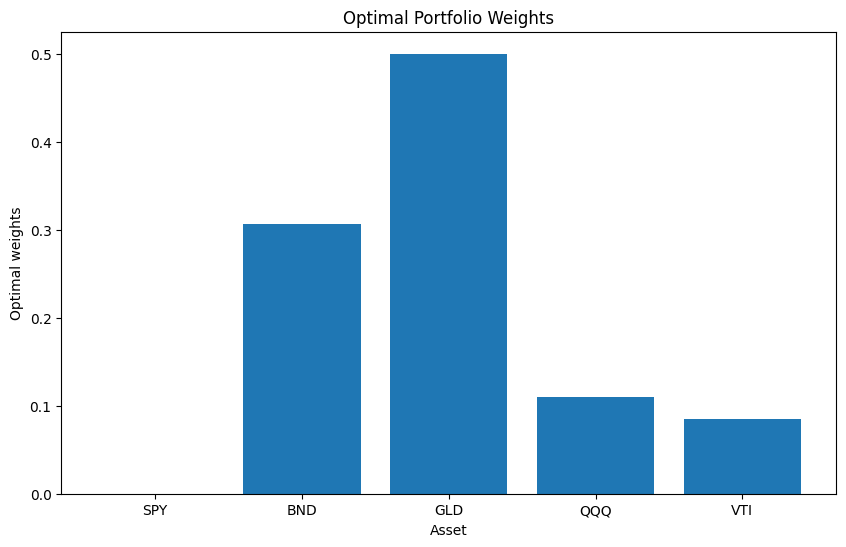

In [ ]:
plt.figure(figsize=(10, 6))
plt.xlabel("Asset")
plt.ylabel("Optimal weights")
plt.title("Optimal Portfolio Weights")
plt.bar(tickers, optimal_weights)
plt.show()